In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

import pattrex.plotting_mpl as plt_rex
import pattrex.preprocessing as pre_rex
import pattrex.fitting as fit_rex
import pattrex.unit_circles as uc_rex




In [14]:
dt = np.dtype([('x', np.float), ('y', np.float), ('lable', np.float)])  # g is byte-string

data = np.loadtxt('data/data2-train.dat', dtype=dt, comments='#', delimiter=None)

x = np.array([d[0] for d in data])#x
y = np.array([d[1] for d in data])#y
lable = np.array([d[2] for d in data])#label

X = np.vstack((x, y, lable))  # data is going to be column-wise
X.shape

# split
X_pos, X_neg = pre_rex.split_data(X, True, 2, [1.0, -1.0])
print("Positive :", X_pos.shape[1], "; Negative :", X_neg.shape[1])


Positive : 128 ; Negative : 128


<IPython.core.display.Javascript object>


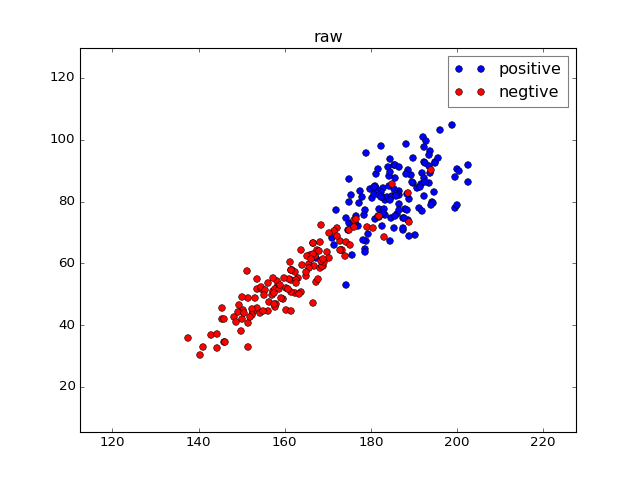

In [16]:
# plotting
fig = plt.figure()
axs = fig.add_subplot(111)

# limits for the axes
X_ = np.vstack((x, y))  # only the measurements; data is col-wise
xmin, ymin = X_.min(axis=1)
xmax, ymax = X_.max(axis=1)

xlim = [xmin-25, xmax+25]  # purely for looks
ylim = [ymin-25, ymax+25]

plt_rex.plot2d(X_pos, colwise_data=True, hatch='bo', x_lim=xlim, y_lim=ylim, 
              show=False, axs=axs, set_aspect_equal=False, plotlabel="positive")
plt_rex.plot2d(X_neg, colwise_data=True, hatch='ro', x_lim=xlim, 
               y_lim=ylim, show=False, axs=axs, set_aspect_equal=False, 
               plotlabel="negtive", title="raw")